# Project 2


# Movie Genre Classification

Classify a movie genre based on its plot.

<img src="moviegenre.png"
     style="float: left; margin-right: 10px;" />




https://www.kaggle.com/c/miia4200-20191-p2-moviegenreclassification/overview


### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 20% API
- 30% Create a solution using with a Machine Learning algorithm - Presentation (5 slides)
- 50% Performance in the Kaggle competition (Normalized acording to class performance in the private leaderboard)


### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

In [0]:
!cat /proc/cpuinfo

**Integrantes: **


*   David Fajardo
*   Andrés Motta
*   Diego Restrepo


## 1 Import Libraries and Dataset

In [0]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier

from sklearn.linear_model import LinearRegression,LogisticRegression, Perceptron

from sklearn.svm import LinearSVC

import xgboost as xgb

from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from textblob import TextBlob

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

#porter stemmer
nltk.download('punkt')
from nltk.stem.porter import *
nltk.download('wordnet')

# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
dataTraining = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTraining['genres_str'] = dataTraining['genres']
dataTraining['genres_str'] = dataTraining['genres_str'].str[1:-1]

In [0]:
dataTesting = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

## 2 Descriptivas

#### 2.1 Buscador de peliculas por genero

In [0]:
def X_Filtrado(clase='Drama'):
  con = dataTraining['genres_str'].str.find(clase) != -1
  genres = dataTraining.loc[con]
 
  return genres

print(X_Filtrado('News').shape)
X_Filtrado('News').head(7)

(7, 6)


,year,title,plot,genres,rating,genres_str
10953,2013,Kids for Cash,kids for cash is a riveting look behind the no...,"['Documentary', 'Crime', 'Drama', 'News']",7.1,"'Documentary', 'Crime', 'Drama', 'News'"
1891,2013,Al midan,' the square ' is an intimate observational d...,"['Documentary', 'Drama', 'History', 'News']",8.1,"'Documentary', 'Drama', 'History', 'News'"
2856,2008,Burma VJ: Reporter i et lukket land,"using smuggled footage , this documentary tel...","['Documentary', 'History', 'News']",8.0,"'Documentary', 'History', 'News'"
4484,2013,Terms and Conditions May Apply,terms and conditions may apply examines the co...,"['Documentary', 'News']",7.4,"'Documentary', 'News'"
10734,2014,The Internet's Own Boy: The Story of Aaron Swartz,the story of programming prodigy and informati...,"['Documentary', 'Biography', 'Crime', 'News']",8.1,"'Documentary', 'Biography', 'Crime', 'News'"
3429,2014,Showrunners: The Art of Running a TV Show,' showrunners ' is the first ever feature len...,"['Documentary', 'Biography', 'News']",6.8,"'Documentary', 'Biography', 'News'"
2603,2011,If a Tree Falls: A Story of the Earth Liberati...,marshall curry ' s documentary tells a timely ...,"['Documentary', 'Biography', 'Crime', 'Drama',...",7.2,"'Documentary', 'Biography', 'Crime', 'Drama', ..."


In [0]:
ind=1869
print('title:',dataTraining.loc[ind,'title'])
print('genres:',dataTraining.loc[ind,'genres_str'])
print('plot:',dataTraining.loc[ind,'plot'])

title: Delta Farce
genres: 'Action', 'Adventure', 'Comedy'
plot: when three small town national guardsmen bound for iraq are unknowingly dropped into mexico ,  their confusion leads them to  " liberate "  a small village from a band of corrupt federales


#### 2.2 Cantidad de peliculas por genero

In [0]:
cant=dataTraining['genres_str'].str.split(',\s+').apply(lambda x: pd.Series(x).value_counts()).sum().to_frame().sort_values(by=[0],ascending=False)
cant['prop']=cant[0]/dataTraining.shape[0]
cant

,0,prop
'Drama',3965.0,0.502217
'Comedy',3046.0,0.385814
'Thriller',2024.0,0.256365
'Romance',1892.0,0.239645
'Crime',1447.0,0.183281
'Action',1303.0,0.165041
'Adventure',1024.0,0.129702
'Horror',954.0,0.120836
'Mystery',759.0,0.096137
'Sci-Fi',723.0,0.091577


## 3 Balanceo

Problema en el cross validation, por culpa de tener 7 registros de News. Se realizara un over-sampling para este genero.

In [0]:
#13 BALANCEO, Añadir + peliculas de news
dataTraining=dataTraining.append([X_Filtrado('News')]*1,ignore_index=True)

cant=dataTraining['genres_str'].str.split(',\s+').apply(lambda x: pd.Series(x).value_counts()).sum().to_frame().sort_values(by=[0],ascending=False)
cant['prop']=cant[0]/dataTraining.shape[0]
cant

,0,prop
'Drama',3968.0,0.502151
'Comedy',3046.0,0.385472
'Thriller',2025.0,0.256264
'Romance',1892.0,0.239433
'Crime',1450.0,0.183498
'Action',1303.0,0.164895
'Adventure',1024.0,0.129587
'Horror',954.0,0.120729
'Mystery',759.0,0.096052
'Sci-Fi',723.0,0.091496


## 4 Feature Engineering

### 4.1 Sobre Training

In [0]:
for i in dataTraining.index:
    dataTraining.loc[i,'q_genres']=len(dataTraining.loc[i,'genres_str'].split())
    dataTraining.loc[i,'words']=len(dataTraining.loc[i,'plot'].split())
    dataTraining.loc[i,'title_words']=len(dataTraining.loc[i,'title'].split())

dataTraining['sentiment'] = dataTraining['plot'].astype(str).apply(lambda tweet: TextBlob(tweet).sentiment.polarity)


stop = stopwords.words('english') 
dataTraining['stopwords'] = dataTraining['plot'].apply(lambda x: len([x for x in x.split() if x in stop]))

dataTraining['word_count'] = dataTraining['plot'].apply(lambda x: len(str(x).split(" ")))

dataTraining['perc_stopwords']=dataTraining['stopwords']/dataTraining['word_count']

#Longitud del plot en caracteres
dataTraining['plot_length'] = dataTraining['plot'].astype(str).apply(lambda word: sum(len(word) for word in word.split()))

#Longitud promedio de las palabras del plot
dataTraining['word_avg_length'] =dataTraining['plot_length']/dataTraining['words'] 

#Número de  signos de puntuación por 
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
dataTraining['punctuation'] = dataTraining['plot'].astype(str).apply(lambda s: count(s,set(string.punctuation)))

#conteo de digitos
dataTraining['digits'] = dataTraining['plot'].astype(str).apply(lambda s: count(s,set(string.digits)))

#'plot_length','word_avg_length','punctuation','digits'

print(dataTraining.shape)
dataTraining.head()

(7902, 17)


,year,title,plot,genres,rating,genres_str,q_genres,words,title_words,sentiment,stopwords,word_count,perc_stopwords,plot_length,word_avg_length,punctuation,digits
0,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0,"'Short', 'Drama'",2.0,254.0,1.0,-0.017817,107,283,0.378092,954,3.755906,32,0
1,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6,"'Comedy', 'Crime', 'Horror'",3.0,18.0,6.0,0.500000,7,18,0.388889,77,4.277778,1,0
2,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2,"'Drama', 'Film-Noir', 'Thriller'",3.0,141.0,3.0,0.005000,61,155,0.393548,583,4.134752,17,0
3,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4,'Drama',1.0,382.0,2.0,0.047245,162,414,0.391304,1654,4.329843,34,0
4,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6,"'Action', 'Crime', 'Thriller'",3.0,193.0,2.0,-0.066667,86,203,0.423645,825,4.274611,14,0


### 4.2 Sobre Testing

In [0]:
for i in dataTesting.index:
    dataTesting.loc[i,'words']=len(dataTesting.loc[i,'plot'].split())
    dataTesting.loc[i,'title_words']=len(dataTesting.loc[i,'title'].split())
    
dataTesting['sentiment'] = dataTesting['plot'].astype(str).apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

import nltk
#nltk.download('stopwords')

#from nltk.corpus import stopwords
stop = stopwords.words('english') 
dataTesting['stopwords'] = dataTesting['plot'].apply(lambda x: len([x for x in x.split() if x in stop]))

dataTesting['word_count'] = dataTesting['plot'].apply(lambda x: len(str(x).split(" ")))

dataTesting['perc_stopwords']=dataTesting['stopwords']/dataTesting['word_count']

#Longitud del plot en caracteres
dataTesting['plot_length'] = dataTesting['plot'].astype(str).apply(lambda word: sum(len(word) for word in word.split()))

#Longitud promedio de las palabras del plot
dataTesting['word_avg_length'] =dataTesting['plot_length']/dataTesting['words'] 

#Número de  signos de puntuación por 
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
dataTesting['punctuation'] = dataTesting['plot'].astype(str).apply(lambda s: count(s,set(string.punctuation)))

#conteo de digitos
dataTesting['digits'] = dataTesting['plot'].astype(str).apply(lambda s: count(s,set(string.digits)))



print(dataTesting.shape)
dataTesting.head()

(3383, 13)


,year,title,plot,words,title_words,sentiment,stopwords,word_count,perc_stopwords,plot_length,word_avg_length,punctuation,digits
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ....",99.0,4.0,-0.038889,42,107,0.392523,361,3.646465,11,0
4,1978,Midnight Express,"the true story of billy hayes , an american c...",24.0,2.0,0.175000,9,25,0.360000,105,4.375000,2,0
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...,401.0,2.0,0.039571,171,441,0.387755,1598,3.985037,48,0
6,1950,Crisis,husband and wife americans dr . eugene and mr...,212.0,1.0,-0.019822,94,234,0.401709,896,4.226415,22,0
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...,208.0,2.0,-0.146667,79,234,0.337607,850,4.086538,29,0


## 5 Vectorizer

### 5.1 stems, lemmas, etc

In [0]:
#PORTER STEMMER
def stemmer(X):
  porter=PorterStemmer()
  #lancaster=LancasterStemmer()

  #tokenize
  X=X.apply(nltk.word_tokenize)

  #stemming
  X=X.apply(lambda x: [porter.stem(y) for y in x])

  for i in dataTraining.index:
      list1=X.loc[i]
      X.loc[i]=' '.join(list1)

  return X

#PORTER STEMMER
def stemmerT(X):
  porter=PorterStemmer()
  #lancaster=LancasterStemmer()

  #tokenize
  X=X.apply(nltk.word_tokenize)

  #stemming
  X=X.apply(lambda x: [porter.stem(y) for y in x])

  for i in dataTesting.index:
      list1=X.loc[i]
      X.loc[i]=' '.join(list1)

  return X

In [0]:
# LEMMATIZATION
def lemmer(X):
  #w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
  lemmatizer=nltk.stem.WordNetLemmatizer()

  X=X.apply(nltk.word_tokenize)

  X=X.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

  for i in dataTraining.index:
      list1=X.loc[i]
      X.loc[i]=' '.join(list1)

  return X

def lemmerT(X):
  #w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
  lemmatizer=nltk.stem.WordNetLemmatizer()

  X=X.apply(nltk.word_tokenize)

  X=X.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

  for i in dataTesting.index:
      list1=X.loc[i]
      X.loc[i]=' '.join(list1)

  return X

### 5.2 Definir matriz de palabras a vectorizar

In [0]:
X = (dataTraining['title']+" ")+dataTraining['plot']
X.head()

0    Most most is the story of a single father who ...
1    How to Be a Serial Killer a serial killer deci...
2    A Woman's Face in sweden ,  a female blackmail...
3    Executive Suite in a friday afternoon in new y...
4    Narrow Margin in los angeles ,  the editor of ...
dtype: object

### 5.3 create vectorizers

#### 5.3.1 Vectorizador del plot

In [0]:
X=lemmer(stemmer(X))

In [0]:
vect = CountVectorizer(lowercase=False,ngram_range=(1, 2),max_features=8000, stop_words='english')

X_dtm = vect.fit_transform(X)
print(X_dtm.shape)
X_dtm

(7902, 8000)


<7902x8000 sparse matrix of type '<class 'numpy.int64'>'
	with 430674 stored elements in Compressed Sparse Row format>

In [0]:
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=8000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

#### 5.3.2 Vectorizador del Title

In [0]:
Title=dataTraining['title']
Title=lemmer(stemmer(Title))

In [0]:
vectTitle = CountVectorizer(max_features=2000, stop_words='english')
#vectTitle = TfidfVectorizer(max_features=4000)

X_dtm_T = vectTitle.fit_transform(Title)
print(X_dtm_T.shape)
X_dtm_T

(7902, 2000)


<7902x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 11390 stored elements in Compressed Sparse Row format>

#### 5.3.3 revision palabras de vectores (por hacer):
- quitar numeros?
- dejar raices? ej: (action, actions), (activities, activity); etc...
- probar con 64 reps de titulo

In [0]:
print(vect.get_feature_names()[:100])

['10', '13', '3D', 'An', 'At', 'Be', 'Do', 'Go', 'II', 'In', 'Is', 'It', 'Me', 'My', 'No', 'On', 'To', 'Up', 'We', 'aaron', 'abandon', 'abandon hi', 'abbey', 'abbi', 'abbott', 'abduct', 'abe', 'abigail', 'abil', 'abl', 'abl convinc', 'abl escap', 'abner', 'aboard', 'abort', 'abound', 'abov', 'abraham', 'abraham lincoln', 'abroad', 'abruptli', 'absenc', 'absent', 'absolut', 'absorb', 'abus', 'abyss', 'academ', 'academi', 'academi award', 'accept', 'accept invit', 'accept job', 'accept offer', 'access', 'accid', 'accident', 'accident kill', 'acclaim', 'accompani', 'accompani hi', 'accomplic', 'accomplish', 'accord', 'account', 'accur', 'accus', 'accus murder', 'ace', 'achiev', 'achiev goal', 'achiev hi', 'acknowledg', 'acquaint', 'acquir', 'acr', 'act', 'act hi', 'act like', 'action', 'activ', 'activist', 'actor', 'actress', 'actual', 'ad', 'adam', 'adapt', 'add', 'addi', 'addict', 'addit', 'address', 'adel', 'adjust', 'administr', 'admir', 'admit', 'adolesc', 'adopt']


In [0]:
print(vectTitle.get_feature_names()[:100])

['000', '10', '100', '11', '1138', '12', '13', '1303', '13th', '17', '18', '20', '2000', '21', '22', '28', '29', '30', '3d', '40', '50', '7th', '80', 'abbott', 'abomin', 'abov', 'abraham', 'absolut', 'abyss', 'academi', 'accid', 'accident', 'ace', 'acr', 'act', 'action', 'activ', 'actual', 'adam', 'addict', 'adult', 'adventur', 'affair', 'africa', 'african', 'afternoon', 'age', 'agent', 'ai', 'air', 'airborn', 'airplan', 'airport', 'al', 'alabama', 'alamo', 'alaska', 'albert', 'alex', 'alexand', 'algier', 'ali', 'alic', 'alien', 'aliv', 'alley', 'allig', 'allow', 'almighti', 'alon', 'alter', 'alway', 'amaz', 'america', 'american', 'amigo', 'amityvil', 'anaconda', 'anatomi', 'anchorman', 'angel', 'angri', 'angu', 'ani', 'anim', 'anna', 'annabel', 'anni', 'anonym', 'anoth', 'ant', 'anyth', 'apach', 'apart', 'ape', 'apocalyps', 'apollo', 'appl', 'appli', 'arizona']


### 5.4 Create sparse matrix with vector and with numeric features

In [0]:
features = dataTraining[['year','words','title_words','sentiment','stopwords','perc_stopwords','plot_length','word_avg_length','punctuation']].to_sparse()
featuresTest = dataTesting[['year','words','title_words','sentiment','stopwords','perc_stopwords','plot_length','word_avg_length','punctuation']].to_sparse()

from scipy.sparse import hstack
X_sparse=hstack((X_dtm,X_dtm_T, features.astype(float)))
print(X_sparse.shape)
X_sparse

(7902, 10009)


<7902x10009 sparse matrix of type '<class 'numpy.float64'>'
	with 512912 stored elements in COOrdinate format>

### 5.5 Parametros optimos de los vectorizadores con cross validation

#### 5.5.1 ngrams (1,n) optimo

2 0.8742991784515408
3 0.8727041299815345
4 0.8742729726558949
5 0.8725149846774637
6 0.8736090198317136


Text(0, 0.5, 'metric')

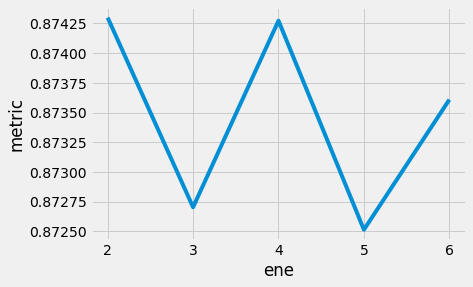

In [0]:
range_ene=[2,3,4,5,6]
accuracy_scores=[]

for ene in range_ene:
  
  vect = CountVectorizer(lowercase=False,ngram_range=(1, ene),max_features=8000, stop_words='english')
  X_dtm = vect.fit_transform(X)
  from scipy.sparse import hstack
  X_sparse=hstack((X_dtm,X_dtm_T, features))
  metric=cross_val_score(clf, X_sparse, y_genres, cv=3, scoring='roc_auc').mean()
  accuracy_scores.append(metric)
  print(ene,metric)
  
plt.plot(range_ene, accuracy_scores)
plt.xlabel('ene')
plt.ylabel('metric')

Se seleccionara ngrams(1,2) para el plot

#### 5.5.2 min_df optimo:

2 0.8722349293042696
3 0.8731238226607171
4 0.8720413460358242
5 0.872830253074025
6 0.8739289229477105


Text(0, 0.5, 'metric')

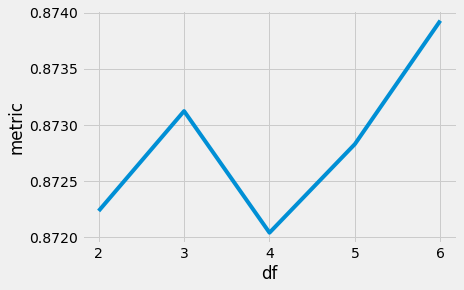

In [0]:
range_min_df=[2,3,4,5,6]
accuracy_scores=[]

for df in range_min_df:
  
  vect = CountVectorizer(lowercase=False,min_df=df,ngram_range=(1, 2),max_features=8000, stop_words='english')
  X_dtm = vect.fit_transform(X)
  from scipy.sparse import hstack
  X_sparse=hstack((X_dtm,X_dtm_T, features))
  metric=cross_val_score(clf, X_sparse, y_genres, cv=3, scoring='roc_auc').mean()
  accuracy_scores.append(metric)
  print(df,metric)
  
plt.plot(range_min_df, accuracy_scores)
plt.xlabel('df')
plt.ylabel('metric')

Da mejores resultados con el min_df estandar: min_df=1,   parametros mayores a 6 pueden dar problema con las categorias que tienen pocos registros.

Se selecciona min_df=1

## 6 Create y

In [0]:
dataTraining['genres'].head()

0                    ['Short', 'Drama']
1         ['Comedy', 'Crime', 'Horror']
2    ['Drama', 'Film-Noir', 'Thriller']
3                             ['Drama']
4       ['Action', 'Crime', 'Thriller']
Name: genres, dtype: object

In [0]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
#del y_genres
y_genres = le.fit_transform(dataTraining['genres'])

In [0]:
dataTraining['genres'].head()

0                  [Short, Drama]
1         [Comedy, Crime, Horror]
2    [Drama, Film-Noir, Thriller]
3                         [Drama]
4       [Action, Crime, Thriller]
Name: genres, dtype: object

In [0]:
print(y_genres.shape)
y_genres

(7902, 24)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

## 7 Train/Test Spliting

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_sparse, y_genres, test_size=0.3, random_state=4200)

## 8 Random Forest Tuning  

### 8.1 Tuning Max-Depth

1 0.6994675865229265
2 0.7461608403575418
3 0.7707718213494507
4 0.7800738155850616
5 0.7875983501615954
6 0.7920233483678504
7 0.7927788239931702
8 0.7993161730148358
9 0.8023765078849413
10 0.806171642456749
11 0.806874361650136
12 0.8085424971922763
13 0.8102148728056627
14 0.8095892388851755
15 0.8104175258809162
16 0.8084220599455539
17 0.8099941274647516
19 0.8105101775632111
21 0.8119335975504924
23 0.8128215752596667
25 0.815165535547704
27 0.8143129163155981
29 0.8176917966073821
31 0.8171437765793396
33 0.8206698657678304
35 0.821046448121428
37 0.8232406388506002
39 0.8257788364022022
(0.8257788364022022, 39)


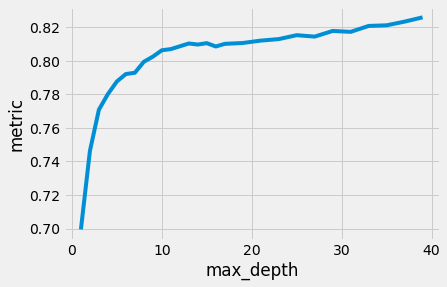

In [0]:
# list of values to try for max_depth
max_depth_range = list(range(1, 16+1))+list(range(17,40,2))

# list to store the average RMSE for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score

for depth in max_depth_range:
    clf = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced',n_jobs=-1, n_estimators=21, max_depth=depth, random_state=42))
    metric=cross_val_score(clf, X_sparse, y_genres, cv=3, scoring='roc_auc').mean()
    accuracy_scores.append(metric)
    print(depth,metric)
    
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('metric')
# show the best accuracy and the corresponding max_depth
print(sorted(zip(accuracy_scores, max_depth_range))[::-1][0])

Se seleccionara valores mayores a 40

### 8.2 Tuning n_estimators

10 0.7781152456652517
60 0.8547166818469688
110 0.8634830922732698
160 0.867079694448913
210 0.868712938684375
260 0.8699127037483092


Text(0, 0.5, 'metric')

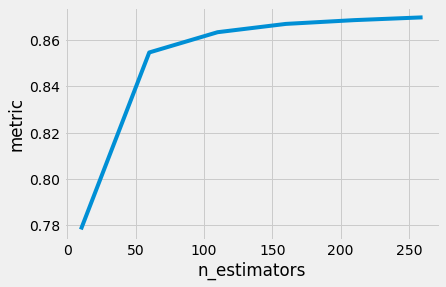

In [0]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 50)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

for estimator in estimator_range:
    clf = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced',n_jobs=-1, n_estimators=estimator, max_depth=37, random_state=42))
    
    metric=cross_val_score(clf, X_sparse, y_genres, cv=3, scoring='roc_auc').mean()
    accuracy_scores.append(metric)
    print(estimator,metric)
    
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('metric')

Se seleccionaran valores mayores a 200

## 9 Train multi-class multi-label model

In [0]:
rf = RandomForestClassifier(class_weight='balanced',n_jobs=-1, n_estimators=260, max_depth=60, max_features='auto', random_state=42000)
calrf = CalibratedClassifierCV(rf, cv=3, method='sigmoid')
clf = OneVsRestClassifier(calrf )

#clf = ClassifierChain(calrf,order = orden )
#Jugar con el orden del class chain
cols2 = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 
        '0_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery',
        'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', '1_Thriller', '3_War', '2_Western']
orden = [7, 21, 23, 22, 4,5,6,0,8,9,10,11,12,13,14,15,16,17,18,19,20,1,3,2]

#clf = OneVsRestClassifier( LogisticRegression(multi_class='ovr'),n_jobs=-1 )
#clf = OneVsRestClassifier( GradientBoostingClassifier(n_estimators=10))
#clf = OneVsRestClassifier( Perceptron(),n_jobs=-1)
#clf = OneVsRestClassifier( LinearSVC(multi_class='ovr'),n_jobs=-1)


In [0]:
clf.fit(X_train, y_train_genres)

OneVsRestClassifier(estimator=CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=60, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
      ...e,
            random_state=42000, verbose=0, warm_start=False),
            cv=3, method='sigmoid'),
          n_jobs=None)

### 9.1 Cross - Validation

In [0]:
def crossval(folds=3):
  cross=cross_val_score(clf, X_sparse, y_genres, cv=folds, scoring='roc_auc')
  return pd.Series(cross).describe()

In [0]:
#con calibracion de probabilidades y best parameters
crossval(folds=3)

count    3.000000
mean     0.889093
std      0.003432
min      0.885132
25%      0.888063
50%      0.890993
75%      0.891074
max      0.891155
dtype: float64

In [0]:
# sin la calibracion
crossval()

count    3.000000
mean     0.882873
std      0.004047
min      0.878442
25%      0.881124
50%      0.883805
75%      0.885089
max      0.886373
dtype: float64

### 9.2 Predict Training

In [0]:
y_pred_genres = clf.predict_proba(X_test)
y_pred_genres

array([[0.03550196, 0.03424047, 0.01480961, ..., 0.07398513, 0.00694842,
        0.00275113],
       [0.01447851, 0.03121557, 0.00896462, ..., 0.04400353, 0.00710458,
        0.00157358],
       [0.02557892, 0.01616288, 0.00739668, ..., 0.06928308, 0.0077672 ,
        0.00144276],
       ...,
       [0.1008661 , 0.07310094, 0.01242146, ..., 0.11218681, 0.56780324,
        0.00440066],
       [0.01744367, 0.03138568, 0.00852807, ..., 0.07093954, 0.00924119,
        0.0023074 ],
       [0.16678613, 0.42786257, 0.01659349, ..., 0.27216221, 0.01507029,
        0.26992008]])

In [0]:
y_pred_class=clf.predict(X_test)
y_pred_class

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 10 Evaluate ROC

### 10.1 ROC over dataTraining Test (Holdout) set

In [0]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

class_roc_proba = roc_auc_score(y_test_genres, y_pred_genres, average=None)
class_roc_class = roc_auc_score(y_test_genres, y_pred_class, average=None)

print('rocs: \n')

col1 = [roc_auc_score(y_test_genres, y_pred_genres, average='macro'),roc_auc_score(y_test_genres, y_pred_genres, average='weighted')]     
col2 = [roc_auc_score(y_test_genres, y_pred_class, average='macro'),roc_auc_score(y_test_genres, y_pred_class, average='weighted')]
roc_table = pd.DataFrame(index=['macro','weighted'],  data={'predict proba':col1, 'predict class': col2})
print(roc_table)

rocs = pd.DataFrame(class_roc_proba,index=cols,  columns=['roc'])
rocs['class']=class_roc_class
rocs.sort_values(by=['roc'],inplace=True)

print('A perfect predictor gives an AUC-ROC score of 1,\n a predictor which makes random guesses has an AUC-ROC score of 0.5.')
print('\n ROC by Class: ')
rocs

rocs: 

          predict proba  predict class
macro          0.883957       0.659689
weighted       0.842091       0.675676
A perfect predictor gives an AUC-ROC score of 1,
 a predictor which makes random guesses has an AUC-ROC score of 0.5.

 ROC by Class: 


,roc,class
p_Drama,0.755400,0.678583
p_Comedy,0.784495,0.699471
p_Short,0.813795,0.558610
p_Biography,0.834352,0.548937
p_Romance,0.834668,0.692249
p_Thriller,0.837662,0.681261
p_Mystery,0.841094,0.588954
p_Family,0.847401,0.608176
p_History,0.847522,0.515241
p_Musical,0.856956,0.581807


### 10.2 Predict Testing

In [0]:
#X_test=dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['title']+" "+dataTesting['plot']
X_test = (dataTesting['title']+" ")+dataTesting['plot']

#PORTER STEMMER
#from nltk.stem.porter import *
#porter=PorterStemmer()
#lancaster=LancasterStemmer()

#tokenize
X_test=X_test.apply(nltk.word_tokenize)

#stemming
X_test=X_test.apply(lambda x: [porter.stem(y) for y in x])

for i in dataTesting.index:
    list1=X_test.loc[i]
    X_test.loc[i]=' '.join(list1)

# LEMMATIZATION

#w_tokenizer=nltk.tokenize.WhitespaceTokenizer()
#lemmatizer=nltk.stem.WordNetLemmatizer()

X_test=X_test.apply(nltk.word_tokenize)

X_test=X_test.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

for i in dataTesting.index:
    list1=X_test.loc[i]
    X_test.loc[i]=' '.join(list1)



X_test_dtm = vect.transform(X_test)


Title=dataTesting['title']
Title=lemmerT(stemmerT(Title))

X_test_dtm_T = vectTitle.transform(Title)
print(X_test_dtm_T.shape)
X_test_dtm_T

from scipy.sparse import hstack
X_sparseTest=hstack((X_test_dtm,X_test_dtm_T, featuresTest))
print(X_sparseTest.shape)

y_pred_test_genres = clf.predict_proba(X_sparseTest)


(3383, 2000)
(3383, 10009)


In [0]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)

res.head(20)

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.039885,0.055218,0.011614,0.017688,0.414987,0.042232,0.010513,0.619460,0.054141,0.139913,...,0.015159,0.053240,0.001100,0.617443,0.016422,0.006812,0.004713,0.138889,0.008096,0.004495
4,0.065966,0.019204,0.010231,0.780072,0.160264,0.348720,0.093382,0.742588,0.016312,0.017296,...,0.024859,0.021844,0.001100,0.060194,0.009643,0.011057,0.009301,0.134133,0.015376,0.002369
5,0.035280,0.019253,0.006679,0.031990,0.106849,0.513275,0.011034,0.807558,0.012876,0.030324,...,0.010522,0.231479,0.001213,0.182957,0.014713,0.003084,0.009209,0.364827,0.009081,0.002378
6,0.057583,0.032556,0.008314,0.026099,0.103620,0.049570,0.011465,0.755425,0.015807,0.022847,...,0.021634,0.095856,0.001100,0.108340,0.070716,0.003099,0.008427,0.383562,0.025585,0.005164
7,0.064163,0.111583,0.022058,0.027709,0.122309,0.167889,0.012719,0.196154,0.034713,0.430375,...,0.019026,0.091355,0.001115,0.070809,0.890968,0.003636,0.005787,0.286078,0.008290,0.004274
9,0.032041,0.047629,0.006523,0.170903,0.193953,0.049873,0.019861,0.574839,0.012699,0.030931,...,0.033096,0.027661,0.001100,0.120624,0.015003,0.005297,0.032038,0.086934,0.010282,0.009154
11,0.343536,0.277354,0.017424,0.218105,0.209165,0.104391,0.648836,0.325164,0.112125,0.106850,...,0.065629,0.025769,0.001115,0.193927,0.053485,0.006423,0.050542,0.073375,0.009385,0.006193
13,0.446073,0.045433,0.009082,0.016656,0.854715,0.640100,0.009782,0.596229,0.029404,0.055968,...,0.020413,0.022794,0.001100,0.300846,0.016965,0.004292,0.007794,0.337010,0.011559,0.002555
16,0.031742,0.030783,0.007707,0.027552,0.703543,0.026125,0.014347,0.697515,0.012682,0.021020,...,0.014084,0.023779,0.001124,0.745062,0.019762,0.003984,0.007411,0.054347,0.008784,0.001926
21,0.033460,0.112286,0.014527,0.026887,0.755203,0.042377,0.015098,0.492233,0.178143,0.031168,...,0.013229,0.031553,0.001100,0.418357,0.012465,0.006976,0.006500,0.060623,0.006489,0.003124


In [0]:
res.to_csv('pred_genres_text_RF4.csv', index_label='ID')

from google.colab import files
files.download('pred_genres_text_RF4.csv')

# Dash

**URL:**  [18.222.130.105:8888](18.222.130.105:8888)



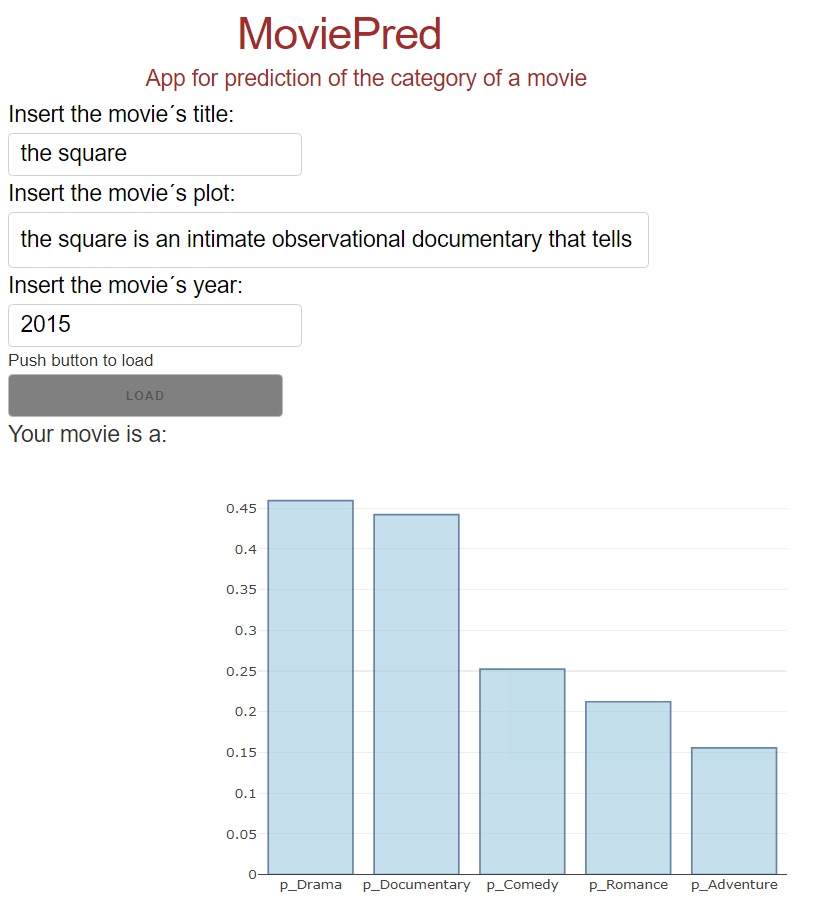

In [6]:
from IPython.display import Image
Image('dash_test.jpeg')